# 🇪🇬 Egypt Landmark Classifier — Colab Ready

This notebook is ready to run on Google Colab. It will:
1. Install required libs.
2. Upload `egypt_landmarks_dataset.zip` and extract it.
3. Prepare tf.data pipelines with augmentation + class weights.
4. Train EfficientNetB0 (transfer learning) and fine-tune.
5. Save model (`.h5` + SavedModel) and `label_map.json`.
6. Provide a simple inference UI to upload one image and get prediction + confidence.

Recommended: Runtime → Change runtime type → GPU. Then Run all cells.

In [1]:
!pip install tensorflow==2.19.0 tensorflow-text==2.19.0 tf-keras==2.19.0 tensorflow-decision-forests==1.12.0 --quiet


In [1]:
%%capture
!pip install -q tensorflow==2.14.0 tensorflow_addons matplotlib seaborn scikit-learn

In [2]:
import os, zipfile, shutil, json
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter

print('TF', tf.__version__)


TF 2.19.0


In [3]:
from google.colab import files
print('Upload your dataset ZIP (egypt_landmarks_dataset.zip)')
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print('Uploaded:', zip_name)

data_root = '/content/data'
if os.path.exists(data_root):
    shutil.rmtree(data_root)
os.makedirs(data_root, exist_ok=True)
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(data_root)

# detect data dir
subfolders = [f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root,f))]
if len(subfolders)==1:
    cand = os.path.join(data_root, subfolders[0])
    if any(os.path.isdir(os.path.join(cand,d)) for d in os.listdir(cand)):
        data_dir = cand
    else:
        data_dir = data_root
else:
    data_dir = data_root
print('Using data dir:', data_dir)
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,d))])
print('Found classes:', len(classes))
for c in classes:
    cnt = len(list(Path(os.path.join(data_dir,c)).rglob('*.*')))
    print(f' - {c}: {cnt}')


Upload your dataset ZIP (egypt_landmarks_dataset.zip)


Saving egypt_landmarks_dataset.zip to egypt_landmarks_dataset.zip
Uploaded: egypt_landmarks_dataset.zip
Using data dir: /content/data/egypt_landmarks_dataset
Found classes: 30
 - Aisha Fahmy Palace: 29
 - Al-Azhar Mosque: 37
 - Amr Ibn Al-Aas Mosque: 30
 - Bab_Zuweila: 28
 - Baron Empain Palace: 55
 - Bent pyramid for senefru: 433
 - Cairo Opera House: 35
 - Cairo University Clock: 21
 - Cairo_Tower: 66
 - Egypt_Renaissance_Statue: 33
 - Egyptian_Museum: 16
 - Grand_Egyptian_Museum: 28
 - Hanging_Church: 47
 - Ibrahim Pasha Statue: 64
 - Khafre Pyramid: 444
 - Muhammad Ali Mosque: 41
 - October_War_Panorama: 18
 - Pyramid of Khufu: 24
 - Pyramid_of_Djoser: 173
 - Qasr_El_Nil_Lion_Statue: 78
 - Saad Zaghloul Statue: 35
 - Senusret_I_Obelisk: 57
 - Simon Bolívar Statue: 31
 - Solar_Boat_Museum: 56
 - Sultan Hassan Mosque: 34
 - Tal'at Harb Statue: 52
 - The Virgin Mary’s tree: 45
 - The_Sphinx_Statue_Inside_the_Museum: 45
 - menkaure pyramid: 173
 - sphinx: 410


In [4]:
# Prepare lists
from sklearn.model_selection import train_test_split
file_paths=[]
labels=[]
for c in classes:
    for p in Path(os.path.join(data_dir,c)).rglob('*.*'):
        file_paths.append(str(p))
        labels.append(c)
print('Total images:', len(file_paths))
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.15, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.17647, stratify=train_labels, random_state=42)
print('Splits ->', len(train_paths), len(val_paths), len(test_paths))


Total images: 2638
Splits -> 1846 396 396


In [5]:
IMG_SIZE = 300
GPU = len(tf.config.list_physical_devices('GPU'))>0
BATCH_SIZE = 32 if GPU else 8
AUTOTUNE = tf.data.AUTOTUNE

label_to_index = {c:i for i,c in enumerate(classes)}
index_to_label = {v:k for k,v in label_to_index.items()}

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

def paths_labels_to_ds(paths, labels_list, shuffle=False):
    labels_idx = [label_to_index[l] for l in labels_list]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels_idx))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(lambda p,l: decode_and_resize(p,l), num_parallel_calls=AUTOTUNE)
    return ds

train_ds = paths_labels_to_ds(train_paths, train_labels, shuffle=True)
val_ds = paths_labels_to_ds(val_paths, val_labels)
test_ds = paths_labels_to_ds(test_paths, test_labels)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.12),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('BATCH_SIZE =', BATCH_SIZE)


BATCH_SIZE = 32


In [6]:
from collections import Counter
counts = Counter(train_labels)
total = sum(counts.values())
class_weights = {}
for lbl, cnt in counts.items():
    class_weights[label_to_index[lbl]] = (1.0 * total) / (len(classes) * cnt)
print('Class weights ready')


Class weights ready


In [7]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', pooling='avg')
base_model.trainable = False
inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs*255.0)
x = base_model(x, training=False)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        38,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,001 (15.59 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
checkpoint = '/content/landmark_best.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


In [9]:
import os
from pathlib import Path
from PIL import Image

# افترض أن 'data_dir' لا يزال معرفًا من الـ Cell الثالث لديك
print(f"Starting file integrity check in: {data_dir}...")
bad_files = []
total_files = 0

for root, _, files in os.walk(data_dir):
    for filename in files:
        total_files += 1
        filepath = os.path.join(root, filename)

        # تجاهل ملفات النظام الشائعة أولاً
        if filename.startswith('.'):
            continue

        try:
            # محاولة فتح الملف كصورة
            img = Image.open(filepath)
            img.verify() # تحقق من سلامة الملف
            img.close()
        except Exception as e:
            # إذا فشلت PIL في الفتح أو التحقق، يتم تسجيل الملف
            bad_files.append(filepath)
            print(f"ERROR: Failed to process file: {filepath} ({e})")

print(f"\n--- Check Complete ---")
print(f"Total files checked: {total_files}")

if bad_files:
    print(f"Found {len(bad_files)} bad files. Please remove them before retraining.")
    print("List of bad files:")
    for f in bad_files:
        print(f)
else:
    print("All files passed the basic image check. The error might be due to a specific TensorFlow issue with a valid file.")

Starting file integrity check in: /content/data/egypt_landmarks_dataset...

--- Check Complete ---
Total files checked: 2638
All files passed the basic image check. The error might be due to a specific TensorFlow issue with a valid file.


In [10]:
E1 = 8
hist1 = model.fit(train_ds, validation_data=val_ds, epochs=E1, class_weight=class_weights, callbacks=callbacks)


Epoch 1/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.0263 - loss: 3.6647
Epoch 1: val_accuracy improved from -inf to 0.12374, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.0266 - loss: 3.6620 - val_accuracy: 0.1237 - val_loss: 3.1558 - learning_rate: 1.0000e-04
Epoch 2/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.1462 - loss: 3.2527
Epoch 2: val_accuracy improved from 0.12374 to 0.32576, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 640ms/step - accuracy: 0.1467 - loss: 3.2531 - val_accuracy: 0.3258 - val_loss: 2.8008 - learning_rate: 1.0000e-04
Epoch 3/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.2727 - loss: 3.0227
Epoch 3: val_accuracy improved from 0.32576 to 0.49242, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 635ms/step - accuracy: 0.2731 - loss: 3.0236 - val_accuracy: 0.4924 - val_loss: 2.5039 - learning_rate: 1.0000e-04
Epoch 4/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.3435 - loss: 2.9404
Epoch 4: val_accuracy improved from 0.49242 to 0.57323, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 652ms/step - accuracy: 0.3442 - loss: 2.9397 - val_accuracy: 0.5732 - val_loss: 2.2587 - learning_rate: 1.0000e-04
Epoch 5/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4941 - loss: 2.6729
Epoch 5: val_accuracy improved from 0.57323 to 0.66414, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 637ms/step - accuracy: 0.4937 - loss: 2.6737 - val_accuracy: 0.6641 - val_loss: 2.0581 - learning_rate: 1.0000e-04
Epoch 6/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.4989 - loss: 2.7006
Epoch 6: val_accuracy improved from 0.66414 to 0.70455, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 653ms/step - accuracy: 0.4990 - loss: 2.6986 - val_accuracy: 0.7045 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 7/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.5585 - loss: 2.3600
Epoch 7: val_accuracy improved from 0.70455 to 0.72980, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 637ms/step - accuracy: 0.5584 - loss: 2.3618 - val_accuracy: 0.7298 - val_loss: 1.7526 - learning_rate: 1.0000e-04
Epoch 8/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.5864 - loss: 2.3333
Epoch 8: val_accuracy improved from 0.72980 to 0.76263, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 637ms/step - accuracy: 0.5864 - loss: 2.3331 - val_accuracy: 0.7626 - val_loss: 1.6410 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


In [11]:
base_model.trainable = True
fine_tune_at = int(len(base_model.layers)*0.6)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.compile(optimizer=keras.optimizers.Adam(5e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
E2 = 12
hist2 = model.fit(train_ds, validation_data=val_ds, epochs=E2, class_weight=class_weights, callbacks=callbacks)


Epoch 1/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.2649 - loss: 2.8682
Epoch 1: val_accuracy improved from 0.76263 to 0.82323, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.2660 - loss: 2.8656 - val_accuracy: 0.8232 - val_loss: 1.5431 - learning_rate: 5.0000e-05
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5273 - loss: 2.2400
Epoch 2: val_accuracy improved from 0.82323 to 0.84596, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 662ms/step - accuracy: 0.5280 - loss: 2.2388 - val_accuracy: 0.8460 - val_loss: 1.3405 - learning_rate: 5.0000e-05
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.7014 - loss: 1.7233
Epoch 3: val_accuracy improved from 0.84596 to 0.86111, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 667ms/step - accuracy: 0.7018 - loss: 1.7222 - val_accuracy: 0.8611 - val_loss: 1.1161 - learning_rate: 5.0000e-05
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.7859 - loss: 1.2677
Epoch 4: val_accuracy improved from 0.86111 to 0.88384, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 662ms/step - accuracy: 0.7861 - loss: 1.2673 - val_accuracy: 0.8838 - val_loss: 0.9747 - learning_rate: 5.0000e-05
Epoch 5/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8383 - loss: 0.9778
Epoch 5: val_accuracy improved from 0.88384 to 0.89646, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 662ms/step - accuracy: 0.8384 - loss: 0.9777 - val_accuracy: 0.8965 - val_loss: 0.8253 - learning_rate: 5.0000e-05
Epoch 6/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8468 - loss: 0.8117
Epoch 6: val_accuracy improved from 0.89646 to 0.90404, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 666ms/step - accuracy: 0.8470 - loss: 0.8114 - val_accuracy: 0.9040 - val_loss: 0.7037 - learning_rate: 5.0000e-05
Epoch 7/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.8747 - loss: 0.7129
Epoch 7: val_accuracy improved from 0.90404 to 0.91414, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 677ms/step - accuracy: 0.8747 - loss: 0.7121 - val_accuracy: 0.9141 - val_loss: 0.6302 - learning_rate: 5.0000e-05
Epoch 8/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.8828 - loss: 0.5816
Epoch 8: val_accuracy did not improve from 0.91414
58/58 ━━━━━━━━━━━━━━━━━━━━ 39s 650ms/step - accuracy: 0.8829 - loss: 0.5810 - val_accuracy: 0.9141 - val_loss: 0.5474 - learning_rate: 5.0000e-05
Epoch 9/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9164 - loss: 0.4069
Epoch 9: val_accuracy improved from 0.91414 to 0.91919, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 658ms/step - accuracy: 0.9162 - loss: 0.4075 - val_accuracy: 0.9192 - val_loss: 0.4950 - learning_rate: 5.0000e-05
Epoch 10/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9126 - loss: 0.3995
Epoch 10: val_accuracy improved from 0.91919 to 0.92424, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 674ms/step - accuracy: 0.9127 - loss: 0.3992 - val_accuracy: 0.9242 - val_loss: 0.4514 - learning_rate: 5.0000e-05
Epoch 11/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9105 - loss: 0.3688
Epoch 11: val_accuracy did not improve from 0.92424
58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 653ms/step - accuracy: 0.9106 - loss: 0.3683 - val_accuracy: 0.9242 - val_loss: 0.4060 - learning_rate: 5.0000e-05
Epoch 12/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9219 - loss: 0.2930
Epoch 12: val_accuracy improved from 0.92424 to 0.93434, saving model to /content/landmark_best.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 38s 658ms/step - accuracy: 0.9220 - loss: 0.2931 - val_accuracy: 0.9343 - val_loss: 0.3696 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 12.


In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test acc:', test_acc)
# حفظ النموذج بصيغة Keras الحديثة (موصى بها)
model.save('/content/landmark_classifier.keras')

# حفظ النموذج بصيغة SavedModel (لو حابب تستخدمه في تطبيق أو TFLite)
model.export('/content/landmark_classifier_saved')

# حفظ بصيغة HDF5 (اختياري لو عايز تكون متوافق مع إصدارات أقدم)
model.save('/content/landmark_classifier.h5')

# حفظ خريطة التصنيفات
with open('/content/label_map.json','w', encoding='utf-8') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9236 - loss: 0.3884
Test acc: 0.9217171669006348
Saved artifact at '/content/landmark_classifier_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_244')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  136293326534800: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136293326533264: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136293670305232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136293670305616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136293614044368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136293670305040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136293670305424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136293614043216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1362936140

NameError: name 'label_map' is not defined

In [13]:
import json
import os

# المسار اللي استخدمته لتوليد train_ds
train_dir = '/content/data/egypt_landmarks_dataset'

# استخراج أسماء الفئات من المجلدات
class_names = sorted(os.listdir(train_dir))

# إنشاء الخريطة
label_map = {i: name for i, name in enumerate(class_names)}

# حفظها كـ JSON
with open('/content/label_map.json', 'w', encoding='utf-8') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=2)

print("✅ label_map.json saved successfully with", len(label_map), "classes!")


✅ label_map.json saved successfully with 30 classes!


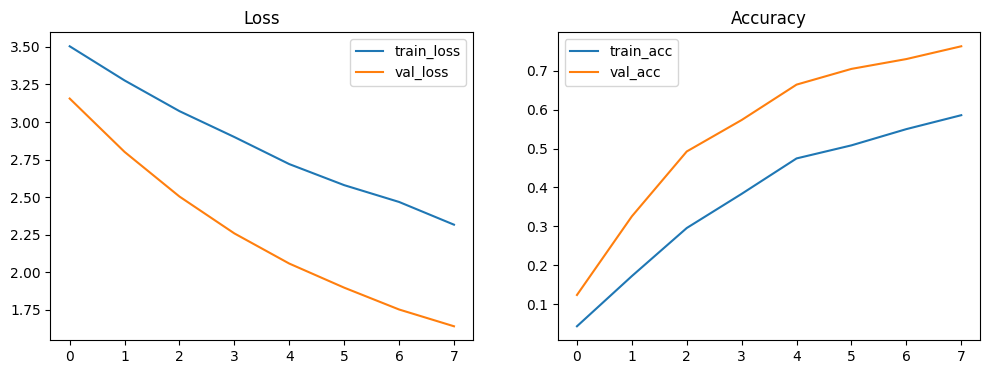

In [14]:
import matplotlib.pyplot as plt
def plot_hist(h1,h2=None):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(h1.history['loss'], label='train_loss')
  plt.plot(h1.history['val_loss'], label='val_loss')
  plt.legend(); plt.title('Loss')
  plt.subplot(1,2,2)
  plt.plot(h1.history['accuracy'], label='train_acc')
  plt.plot(h1.history['val_accuracy'], label='val_acc')
  plt.legend(); plt.title('Accuracy')
  plt.show()
plot_hist(hist1, hist2)


In [27]:
from google.colab import files
from PIL import Image
import numpy as np

print("Upload an image to predict:")
upl = files.upload()


Upload an image to predict:


Saving WhatsApp Image 2025-10-13 at 8.17.11 PM.jpeg to WhatsApp Image 2025-10-13 at 8.17.11 PM.jpeg


In [28]:
# تحميل الصورة واختبار النموذج عليها
for fn in upl.keys():
    img = Image.open(fn).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(np.array(img) / 255.0, axis=0)

    preds = model.predict(x)
    predicted_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    print(f"🏛️ Predicted landmark: {predicted_class} ({confidence:.2%} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
🏛️ Predicted landmark: Cairo_Tower (98.91% confidence)


In [ ]:
# Download artifacts
from google.colab import files as gfiles
gfiles.download('/content/landmark_classifier.h5')
gfiles.download('/content/label_map.json')


In [ ]:
from google.colab import files
import shutil

# اسم ملف الـ ZIP النهائي
zip_filename = "landmark_project_files.zip"

# الملفات اللي عايز تضمها
files_to_zip = [
    "label_map.json",
    "landmark_best.h5",
    "landmark_classifier.h5",
    "landmark_classifier.keras",
]

# لو في مجلد SavedModel وعايز تضيفه كمان:
saved_model_dir = "landmark_classifier_saved"
shutil.make_archive("landmark_classifier_saved", 'zip', saved_model_dir)
files_to_zip.append("landmark_classifier_saved.zip")

# إنشاء الملف المضغوط
with shutil.make_archive("landmark_project_files", 'zip', root_dir='.', base_dir='.') as f:
    pass  # (مش محتاج تعمل حاجة هنا)

# تنزيل الملفات المطلوبة
!zip -r landmark_project_files.zip {' '.join(files_to_zip)}

# تحميل الملف المضغوط على جهازك
files.download(zip_filename)